In [2]:
#!/usr/bin/env python
# coding: utf-8
import itertools
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

stock = "VZ"

# Display Chinese
plt.rcParams['font.sans-serif'] = ['SimHei']
# Display Symbols
plt.rcParams['axes.unicode_minus'] = False
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
# Create directory if not exist
if not os.path.isdir('result'):
    os.mkdir('result')

2.18.0
3.7.0


In [6]:
# arima-lstm=arima-->lstm--->predict
# Read csv file
BASE_DIR = os.path.abspath(os.path.join("..", "..","hongzhen xu","input data"))
print(BASE_DIR)
df = pd.read_csv(BASE_DIR + '\Reversed_' + stock + '_Data_with_PCA.csv')   
# Display first 5 lines
df.head()

e:\PG Year 2\Semester 1\CS6140 10931 Machine Learning\Project\stockPredictModelsProject\hongzhen xu\input data


,timestamp,open,high,low,close,volume,Principal Component 1,Principal Component 2
0,2014-09-30,49.67,50.24,49.600,49.99,13068736,-4.161379,3.951342
1,2014-10-01,49.73,49.95,49.400,49.43,16816055,-4.161379,3.951342
2,2014-10-02,49.70,49.73,49.200,49.29,14430319,-4.161379,3.951342
3,2014-10-03,49.70,49.83,49.495,49.71,12073438,-4.161379,3.951342
4,2014-10-06,49.95,50.26,49.920,50.08,11034363,-4.161379,3.951342


In [186]:
# Got columns we need
data=df['close']
date=df['timestamp']

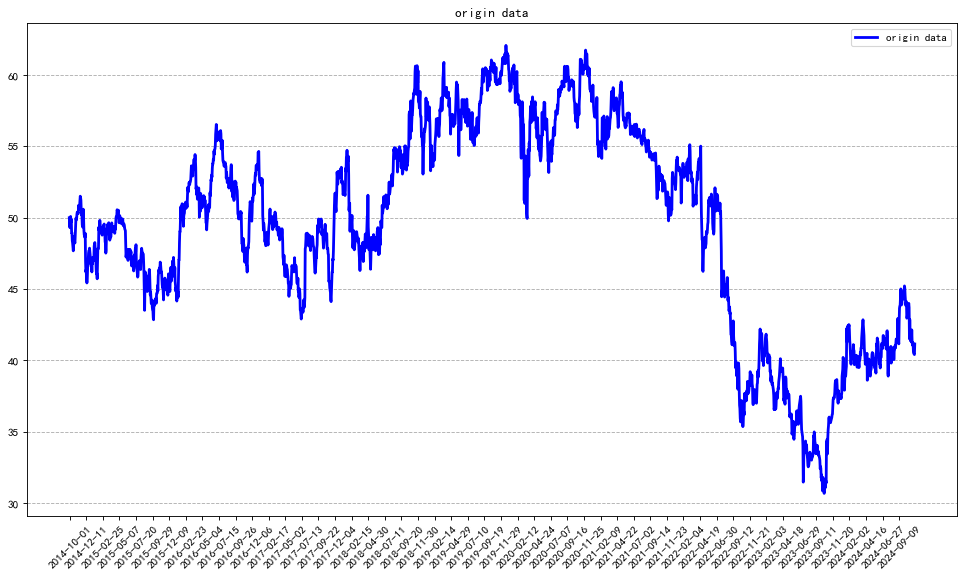

In [187]:
# Display original data
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(date, data, label="origin data", color='b',lw=2.5)  # Alternative option plt.plot(data, label=" ", color='b',lw=2.5) if we don't have date
plt.title("origin data")
plt.grid(which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(data),50),rotation=45) # Optimization for x-axis display
plt.legend()
plt.savefig('result/' + str(stock) + '/origin_data.png') # Save figure 
plt.show()

In [188]:
# Define Augmented Dickey-Fuller (ADF) test function
def adf_val(ts, ts_title):
    '''
    ts: time series, series
    ts_title: title of time series, string
    '''
    # ADF test
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts)

    name = ['adf', 'pvalue', 'usedlag','nobs', 'critical_values', 'icbest']
    values = [adf, pvalue, usedlag, nobs,critical_values, icbest]
    print(list(zip(name, values)))

    return adf, pvalue, critical_values,
    # adf value, p-value of ADF, critical values(1%, 5%, 10%)

In [189]:
# The white noise test(Ljung-Box test) is also called a pure randomness test. When the data is purely random, it is meaningless to analyze the data further. Therefore, it is best to perform a pure randomness test on the data after obtaining it.
def acorr_val(ts):
    '''
    # Ljung-Box test
    ts: time series, series
    return p-value
    '''
    lbvalue, pvalue = acorr_ljungbox(ts, lags=1)  # Ljung-Box result
    return lbvalue, pvalue

def tsplot(date, y, lags=None, figsize=(15, 8)):
    # Merge date and y int DataFrame, ensure that date is x axis
    data = pd.DataFrame({'date': date, 'y': y})
    # ensure date is datetime type
    data['date'] = pd.to_datetime(data['date'])
    # set date to index
    data.set_index('date', inplace=True)

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    # Plot using date as index
    data['y'].plot(ax=ts_ax)
    ts_ax.set_title('origin  data')

    # Draw histogram
    data['y'].plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')

    # Autocorrelation: relation between current value and past value on a time series. Relation will go on if positive.
    plot_acf(data['y'], lags=lags, ax=acf_ax)
    # Can measure a purer correlation between present and past values
    plot_pacf(data['y'], lags=lags, ax=pacf_ax)

    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()

    fig.tight_layout()
    fig.savefig('result/' + str(stock) + '/ACF_PACF.png')  # Save to local
    fig.show()

    return ts_ax, acf_ax, pacf_ax

In [190]:
# transfer date column to float32
ts_data = data.astype('float32')


In [191]:
# Stability test
adf1, pvalue1, critical_values1 = adf_val(ts_data, 'raw time series') # Determine stability on original data
print('adf',adf1)
print('pvalue1',pvalue1)
print('critical_values',critical_values1)
# adf not less than 3 values of critical_values, pvalue not close to 0,so it's not stable, need first order difference
# if p much less than 0.01, it has good stability

# White noise test
aco=acorr_val(ts_data)
print('aco',aco)


[('adf', -1.3672566535095947), ('pvalue', 0.5978691784418595), ('usedlag', 27), ('nobs', 2521), ('critical_values', {'1%': -3.432946577138947, '5%': -2.8626871581881708, '10%': -2.5673806760176046}), ('icbest', 4541.853177683623)]
adf -1.3672566535095947
pvalue1 0.5978691784418595
critical_values {'1%': -3.432946577138947, '5%': -2.8626871581881708, '10%': -2.5673806760176046}
aco ('lb_stat', 'lb_pvalue')


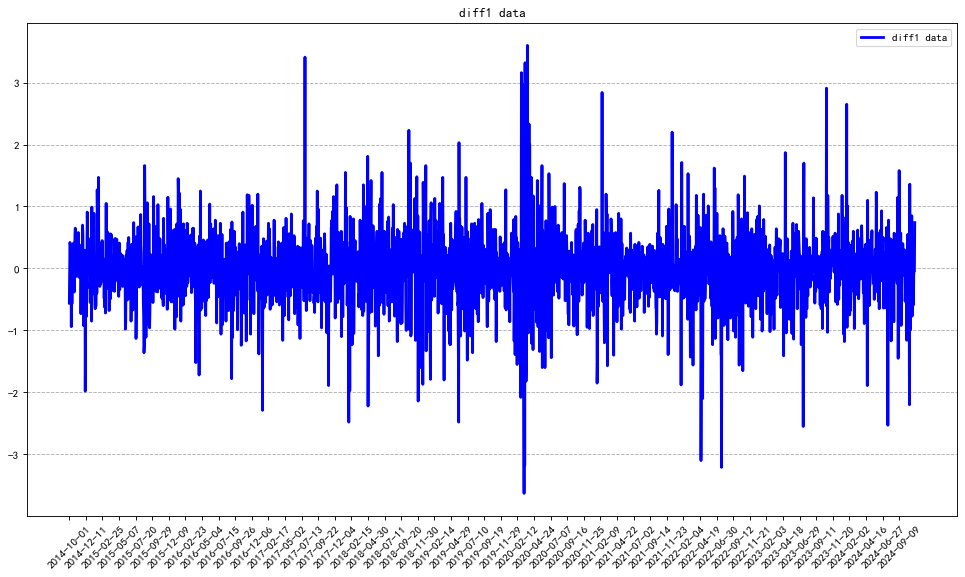

In [192]:
diff1 = ts_data.diff(1)

# Display results of first order difference
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(date,diff1, label="diff1 data", color='b',lw=2.5)
plt.title("diff1 data")
plt.grid(which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(data),50),rotation=45) # Optimization for x-axis display
plt.legend()
plt.savefig('result/' + str(stock) + '/diff1.png')
plt.show()

In [193]:
# Check whether the first-order difference is stationary
adf1, pvalue1, critical_values1 = adf_val(diff1.dropna(), 'raw time series')
print('adf1',adf1)
print('pvalue1',pvalue1)
print('critical_values1',critical_values1)
# Test for white noise in first-order differences
aco1=acorr_val(diff1.dropna())
print('aco1',aco1)
# If the first-order difference is still not stable, the second-order difference can be performed
# In this case, the first-order difference is already stable, so d=1 in the subsequent parameter search

[('adf', -10.972318358662248), ('pvalue', 7.824096580660251e-20), ('usedlag', 26), ('nobs', 2521), ('critical_values', {'1%': -3.432946577138947, '5%': -2.8626871581881708, '10%': -2.5673806760176046}), ('icbest', 4539.6329334901975)]
adf1 -10.972318358662248
pvalue1 7.824096580660251e-20
critical_values1 {'1%': -3.432946577138947, '5%': -2.8626871581881708, '10%': -2.5673806760176046}
aco1 ('lb_stat', 'lb_pvalue')


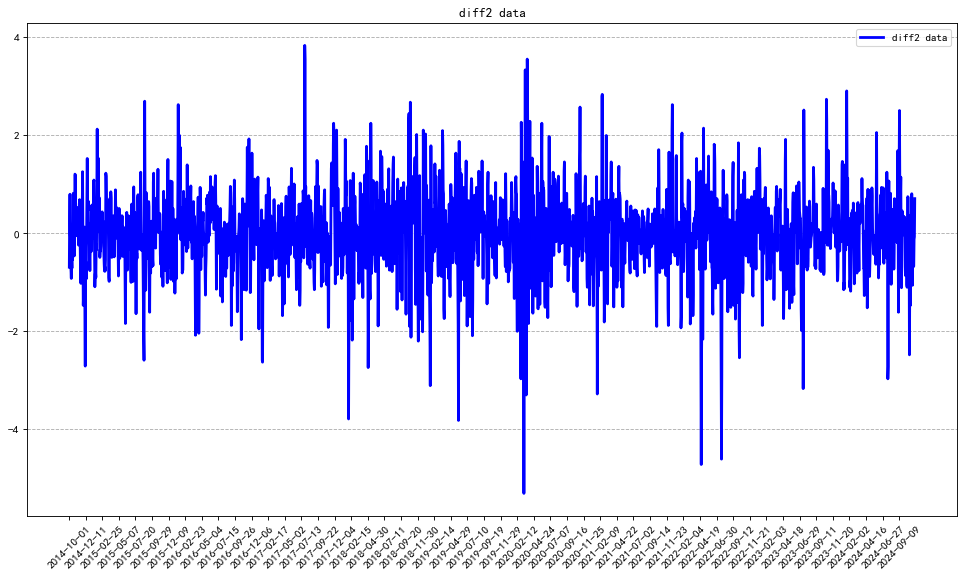

In [194]:
# Second order difference
diff2 = ts_data.diff(2)

# Display second order difference result
fig = plt.figure(figsize=(15, 8), dpi=80)
plt.plot(date,diff2, label="diff2 data", color='b',lw=2.5)
plt.title("diff2 data")
plt.grid(which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(data),50),rotation=45) # Optimization for x-axis display
plt.legend()
plt.savefig('result/' + str(stock) + '/diff2.png')
plt.show()

(<Axes: title={'center': 'origin  data'}, xlabel='date'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: title={'center': 'Partial Autocorrelation'}>)

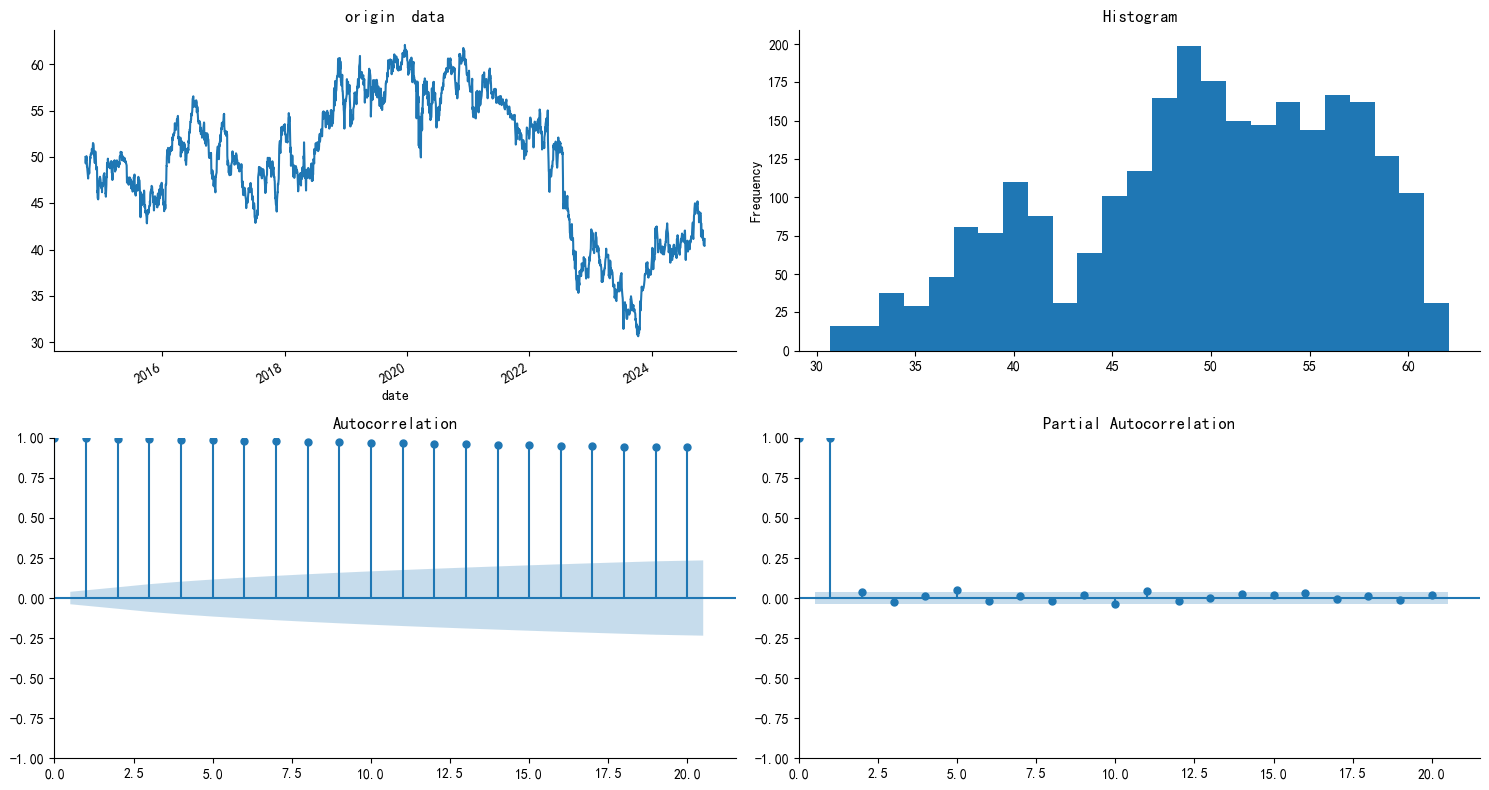

In [195]:
# Display original data, ACF and PACF.
tsplot(date,ts_data, lags=20)

In [196]:
# Determine best arima parameters
# To determine p、q、d of ARIMA, one method is from figures of ACF and PACF, but it's subjective
# Another method is to use AIC or BIC to select, here using AIC

# Calculation based on AIC and BIC
q_arima = range(0, 3) # Determine range of q
d_arima = 1 # Order of difference (d-value)
p_arima = range(0, 3) # Determine range of p
AIC_arima = [] # Define AIC list to store AIC value
ARIMAX_model = [] # Define model parameter list
# Loop to determine which parameter is better
print(p_arima)
print(q_arima)
pdqs = [(x[0], d_arima, x[1]) for x in list(itertools.product(p_arima, q_arima))]
print(pdqs)
for pdq in pdqs:
    try:
        mod =ARIMA(data, order=pdq)
        results = mod.fit()
        print(results)
        print('ARIMA{} - AIC:{}'.format(pdq, results.aic))
        AIC_arima.append(results.aic)
        ARIMAX_model.append(pdq)
    except:
        continue

print('AIC_arima')
print(AIC_arima)
index=AIC_arima.index(min(AIC_arima))
order = ARIMAX_model[index] # Got best p, d, q value
print('order num',order)

range(0, 3)
range(0, 3)
[(0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]
ARIMA(0, 1, 0) - AIC:4590.583162071168
ARIMA(0, 1, 1) - AIC:4586.869974700839
ARIMA(0, 1, 2) - AIC:4587.29103326686
ARIMA(1, 1, 0) - AIC:4586.601006972941
ARIMA(1, 1, 1) - AIC:4587.522520202941
ARIMA(1, 1, 2) - AIC:4588.967782832782
ARIMA(2, 1, 0) - AIC:4587.213547928126
ARIMA(2, 1, 1) - AIC:4582.9059367169875
ARIMA(2, 1, 2) - AIC:4578.568314624854
AIC_arima
[4590.583162071168, 4586.869974700839, 4587.29103326686, 4586.601006972941, 4587.522520202941, 4588.967782832782, 4587.213547928126, 4582.9059367169875, 4578.568314624854]
order num (2, 1, 2)


In [197]:
# According to the results of AIC parameter search, ARIMA parameters are defined as(2,1,2)
order=(0,1,1) # Sometimes you have to manually determine if the best p, d, q are not satifactory

# Construct training data
ndata=np.array(data).reshape(-1,1)# Transfer to array type
# Determine training and test set
train_len=int(len(ndata)*0.8)# 80% training set
train_ar = ndata[:train_len,:]# Obtaining data[row or row interval(:), column or column interval(:)]
test_ar = ndata[train_len:,:]

history = [x for x in train_ar]
print(type(history))
pre = list()

# Train ARIMA model
for t in range(len(test_ar)):
    model = ARIMA(history, order=order)
    model_fit = model.fit() # Model training
    output = model_fit.forecast() # Model prediction
    yhat = output[0]
    pre.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# Data type conversion
pre=np.array(pre)

<class 'list'>
predicted=37.695171, expected=37.150000
predicted=37.173933, expected=37.240000
predicted=37.237097, expected=37.190000
predicted=37.192070, expected=37.870000
predicted=37.840176, expected=37.620000
predicted=37.629722, expected=38.520000
predicted=38.480477, expected=38.300000
predicted=38.308041, expected=38.310000
predicted=38.309913, expected=37.700000
predicted=37.727199, expected=37.880000
predicted=37.873171, expected=38.160000
predicted=38.147188, expected=38.550000
predicted=38.532070, expected=38.620000
predicted=38.616090, expected=39.200000
predicted=39.174079, expected=38.920000
predicted=38.931322, expected=39.020000
predicted=39.016045, expected=38.240000
predicted=38.274677, expected=38.340000
predicted=38.337079, expected=38.980000
predicted=38.951246, expected=38.330000
predicted=38.358084, expected=38.180000
predicted=38.188027, expected=37.070000
predicted=37.120093, expected=36.890000
predicted=36.900218, expected=37.170000
predicted=37.157975, expe

[ 4.99900000e+01 -5.59999182e-01 -1.65863208e-01 ... -1.17503065e-01
 -4.54384297e-02 -4.21030405e-02]


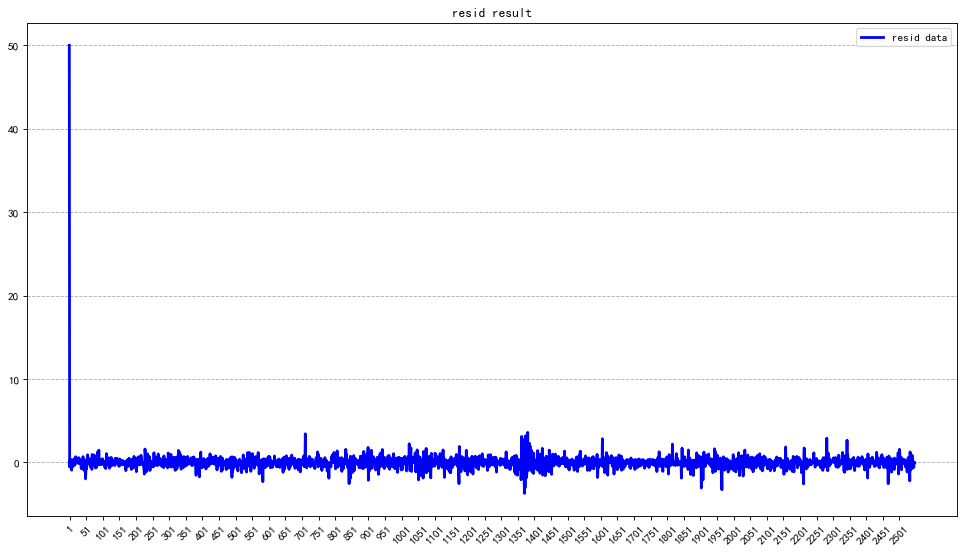

In [198]:
resid=model_fit.resid  # Residue
print(resid)
# Display residual test
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(resid, label="resid data", color='b',lw=2.5)
plt.title("resid result")
plt.grid(which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(data),50),rotation=45) # Optimization for x-axis display
plt.legend()
plt.savefig('result/' + str(stock) + '/resid_result.png')
plt.show()

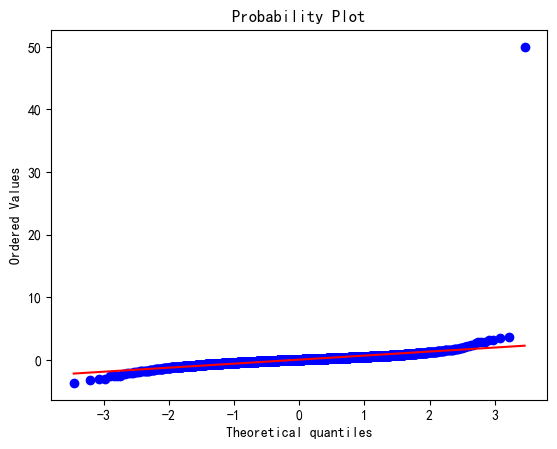

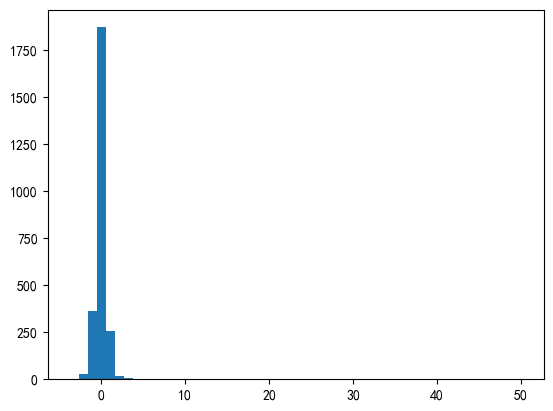

In [199]:
stats.normaltest(resid)# Test whether residual are distributed normally
# q values are mostly lying on straight line, histogram shows normal distribution
stats.probplot(resid, dist="norm", plot=plt)
plt.show()
plt.hist(resid,bins=50)
plt.show()

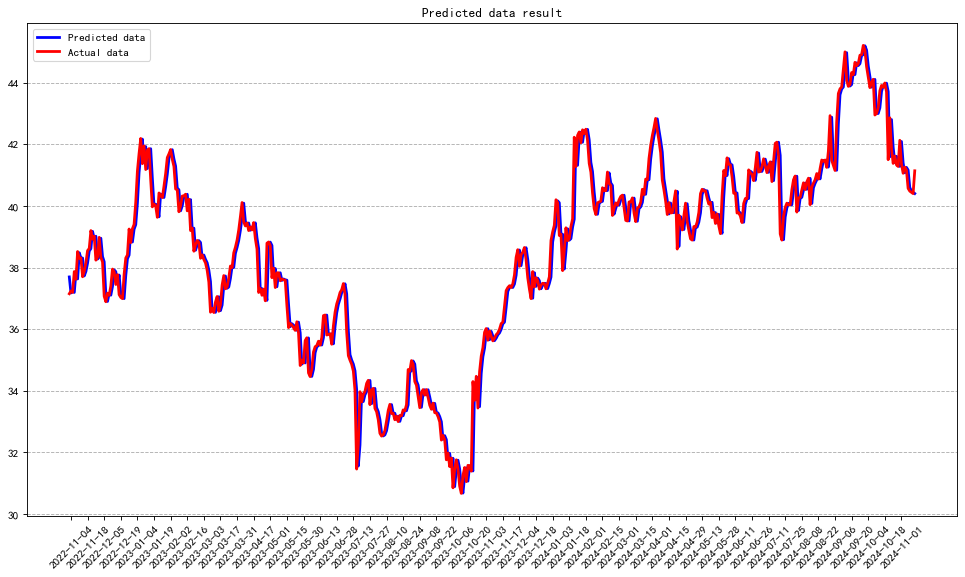

In [ ]:
# Display prediction result
# fig = figure(figsize=(15, 8), dpi=80)
# plt.plot(date[train_len:],pre, label="Predicted data", color='b',lw=2.5) # Alternative option plt.plot(data, label=" ", color='b',lw=2.5) if we don't have date
# plt.plot(date[train_len:],test_ar, label="Actual data", color='r',lw=2.5)
# plt.title("Predicted data result")
# plt.grid(which='major', axis='y', linestyle='--')
# plt.xticks(range(1,len(pre),10),rotation=45) # Optimization for x-axis display
# plt.legend()
# plt.savefig('result/' + str(stock) + '/predict_result.png')
# plt.show()


In [201]:
# Save Arima prediction result to local
result=np.concatenate((pre.reshape(-1,1),test_ar),axis=1)
dg=pd.DataFrame(result,columns=['predict','true'])
dg.to_csv('result/' + str(stock) + '/result.csv')

In [202]:
# train lstm according to value from arima
arima_result = pd.DataFrame(columns=['close']) # Generate new empty DataFrame
arima_result['close'] = test_ar.ravel() # Assign ARIMA test data to empty DataFrame
arima_result['predicted'] = pre.ravel() # Assign ARIMA prediction data to empty DataFrame
arima_result['residuals'] = arima_result['close'] - arima_result['predicted'] # Get residual between these two data

# LSTM part
lstm_data=arima_result['residuals'].values # Get resudual and transfer datatype
# Declare normalization
sc = MinMaxScaler(feature_range=(0, 1))
# Denormalization
sc_data = sc.fit_transform(lstm_data.reshape(-1,1))


In [203]:
seq_len = 2  # time step t-5,t-4,t-3,t-2,t-1 --->t
# transfer to format for LSTM (sample size, step, number of features)
X_train = np.array([sc_data[i : i + seq_len, :] for i in range(sc_data.shape[0] - seq_len)])
y_train = np.array([sc_data[i + seq_len, :] for i in range(sc_data.shape[0]- seq_len)])

print(X_train.shape,y_train.shape)

(508, 2, 1) (508, 1)


In [204]:
# lstm network,keras
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False)) # lstm layer, 64 units
# model.add(LSTM(units=128,activation='tanh',return_sequences=False))#lstm layer, 128 units
model.add(Dropout(0.2))# dropout layer
model.add(Dense(1)) # Fully connected layer
model.compile(loss='mean_squared_error', optimizer='adam')
# training
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)


Epoch 1/100
16/16 - 1s - 41ms/step - loss: 0.1716
Epoch 2/100
16/16 - 0s - 3ms/step - loss: 0.0668
Epoch 3/100
16/16 - 0s - 3ms/step - loss: 0.0174
Epoch 4/100
16/16 - 0s - 3ms/step - loss: 0.0131
Epoch 5/100
16/16 - 0s - 3ms/step - loss: 0.0124
Epoch 6/100
16/16 - 0s - 3ms/step - loss: 0.0119
Epoch 7/100
16/16 - 0s - 3ms/step - loss: 0.0121
Epoch 8/100
16/16 - 0s - 3ms/step - loss: 0.0124
Epoch 9/100
16/16 - 0s - 3ms/step - loss: 0.0119
Epoch 10/100
16/16 - 0s - 3ms/step - loss: 0.0118
Epoch 11/100
16/16 - 0s - 3ms/step - loss: 0.0113
Epoch 12/100
16/16 - 0s - 3ms/step - loss: 0.0119
Epoch 13/100
16/16 - 0s - 3ms/step - loss: 0.0112
Epoch 14/100
16/16 - 0s - 3ms/step - loss: 0.0113
Epoch 15/100
16/16 - 0s - 3ms/step - loss: 0.0117
Epoch 16/100
16/16 - 0s - 3ms/step - loss: 0.0117
Epoch 17/100
16/16 - 0s - 3ms/step - loss: 0.0118
Epoch 18/100
16/16 - 0s - 3ms/step - loss: 0.0111
Epoch 19/100
16/16 - 0s - 3ms/step - loss: 0.0113
Epoch 20/100
16/16 - 0s - 3ms/step - loss: 0.0111
Epoch 21

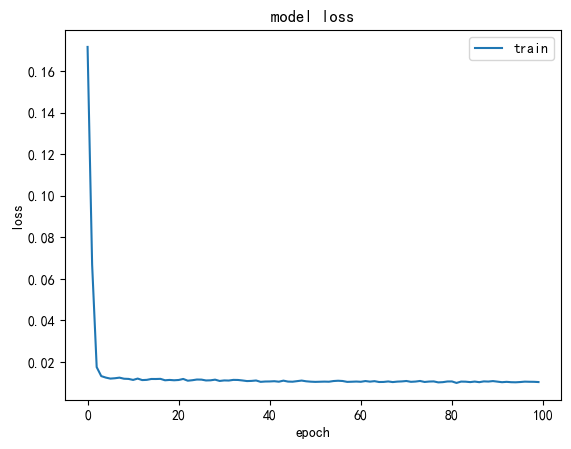

In [205]:
# Display loss of training value
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [206]:
# Predict training set data
lstm_pred = model.predict(X_train)
# inverse transform to lstm_pred
lstm_pred = sc.inverse_transform(lstm_pred) # Denormalized data is the predicted data for incomplete data
# inverse transform to y_train
ytrue = sc.inverse_transform(y_train.reshape(-1,1)) # Denormalized data is the true value of the incomplete data


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [207]:
# dtest is the prediction of arima-lstm model, ytrue is true value
arima_resid=arima_result['predicted'][-len(lstm_pred):].values.astype(float).reshape(-1,1)
dtest=arima_resid+lstm_pred
ytrue=arima_result['close'][-len(ytrue):].values.reshape(-1,1)+ytrue
# Save Arima-LSTM result to local
new_result=np.concatenate((dtest,ytrue),axis=1)
dg=pd.DataFrame(new_result,columns=['predict','true'])
dg.to_csv('result/' + str(stock) + '/arima_lstm_result.csv')

In [208]:
# Calculate indicator
mse = mean_squared_error(ytrue, dtest)
mae = mean_absolute_error(ytrue, dtest)
rmse = np.sqrt(mse)
r2 = r2_score(ytrue,dtest)

print('mse: %.3f' % mse)
print('mae: %.3f' % mae)
print('rmse: %.3f' % rmse)
print('r2: %.3f' % r2)

mse: 1.155
mae: 0.754
rmse: 1.075
r2: 0.889


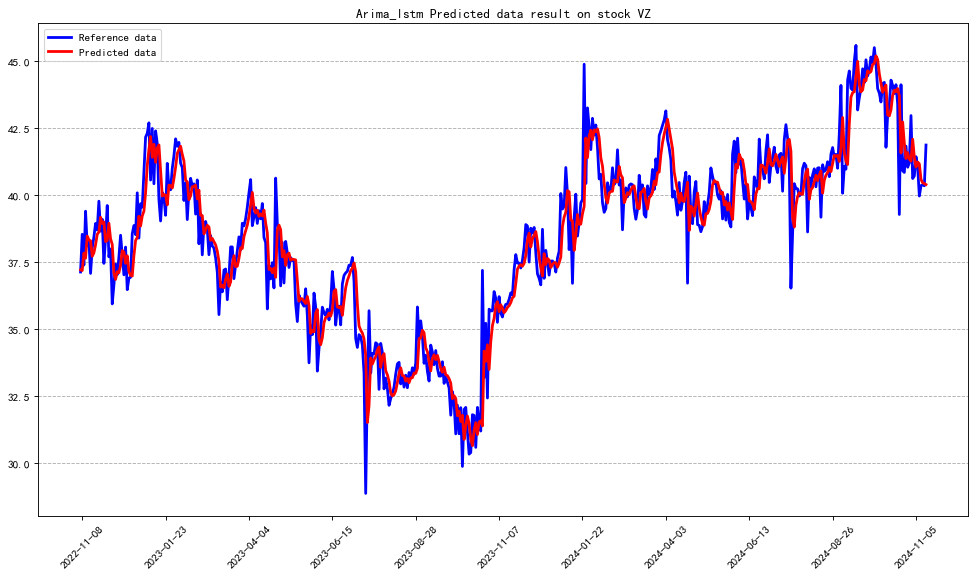

In [209]:
# Display ARIMA-LSTM result
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(date[len(ndata)-len(ytrue):],ytrue, label="Reference data", color='b',lw=2.5) # Alternative option plt.plot(data, label=" ", color='b',lw=2.5) if we don't have date
plt.plot(dtest, label="Predicted data", color='r',lw=2.5)
plt.title("Arima_lstm Predicted data result on stock " + str(stock))
plt.grid(which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(pre),50),rotation=45) # Optimization for x-axis display
plt.legend()
plt.savefig('result/' + str(stock) + '/arima_lstm_predict_result1.png')
plt.show()

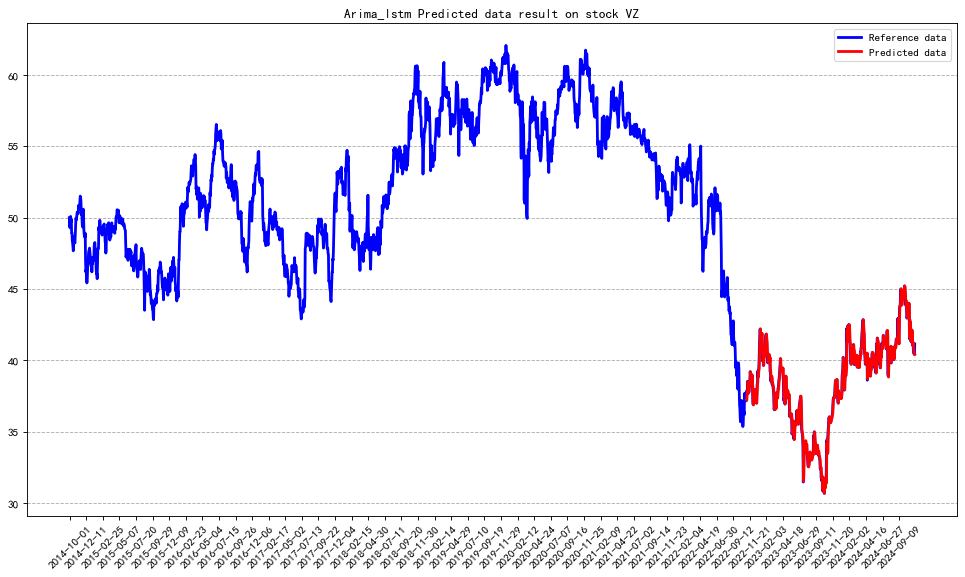

In [210]:
# Display previous result and ARIMA-LSTM result
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(date,ndata, label="Reference data", color='b',lw=2.5) # Alternative option plt.plot(data, label=" ", color='b',lw=2.5) if we don't have date
plt.plot(range(train_len+seq_len,len(ndata)),dtest, label="Predicted data", color='r',lw=2.5)
plt.title("Arima_lstm Predicted data result on stock " + str(stock))
plt.grid(which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(date),50),rotation=45) # Optimization for x-axis display
plt.legend()
plt.savefig('result/' + str(stock) + '/arima_lstm_predict_result2.png')
plt.show()